In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook_connected"  # Use interactive Plotly renderer
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
# For word cloud visualization
from wordcloud import WordCloud
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
# Set a distinct plotting style for this notebook
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style="whitegrid", palette="magma")
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
# 1. Data Loading and Preprocessing
# We use the IMDB dataset provided by Keras.
# Set num_words to limit vocabulary size, and maxlen for sequence length.
num_words = 10000  # Only consider the top 10,000 words
maxlen = 500       # Pad sequences to a maximum length of 500

In [4]:
print("Loading IMDB dataset...")
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)
print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

Loading IMDB dataset...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training set: (25000,) (25000,)
Test set: (25000,) (25000,)


In [5]:
# Pad sequences to ensure uniform length
X_train = pad_sequences(X_train, maxlen=maxlen, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=maxlen, padding='post', truncating='post')

In [6]:
# 2. Model Building with LSTM
embedding_dim = 128

model = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [7]:
# 3. Model Training with Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 89ms/step - accuracy: 0.5015 - loss: 0.6938 - val_accuracy: 0.4938 - val_loss: 0.6943
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.5105 - loss: 0.7004 - val_accuracy: 0.4952 - val_loss: 0.6932
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.5068 - loss: 0.6871 - val_accuracy: 0.5180 - val_loss: 0.6985
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.5276 - loss: 0.6811 - val_accuracy: 0.5032 - val_loss: 0.7045
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.5326 - loss: 0.6668 - val_accuracy: 0.5182 - val_loss: 0.7241


In [8]:
# 4. Model Evaluation
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob >= 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.00      0.01     12500
           1       0.50      1.00      0.67     12500

    accuracy                           0.50     25000
   macro avg       0.63      0.50      0.34     25000
weighted avg       0.63      0.50      0.34     25000



In [9]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[   33 12467]
 [   10 12490]]


In [10]:
# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC Score: {roc_auc:.3f}")


ROC AUC Score: 0.510


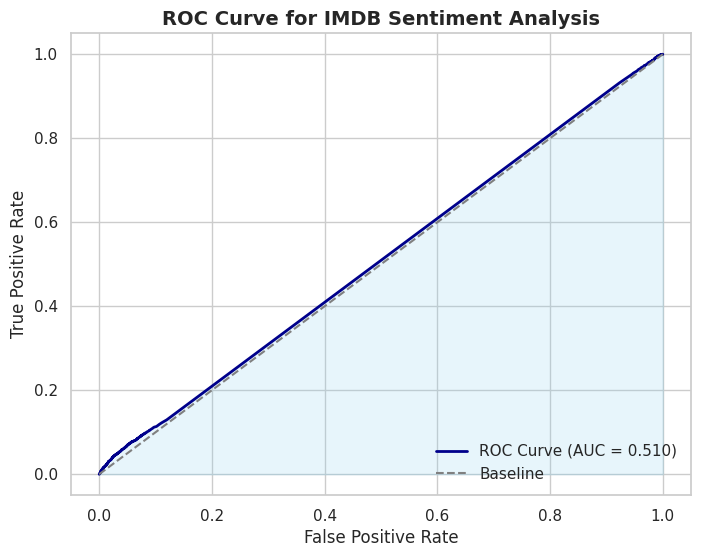

In [18]:
# 5. Visualizations

# Calculate False Positive Rate (FPR), True Positive Rate (TPR) and Thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkblue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Baseline')
plt.fill_between(fpr, tpr, alpha=0.2, color='skyblue')  # Adding a fill for visual appeal
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve for IMDB Sentiment Analysis", fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

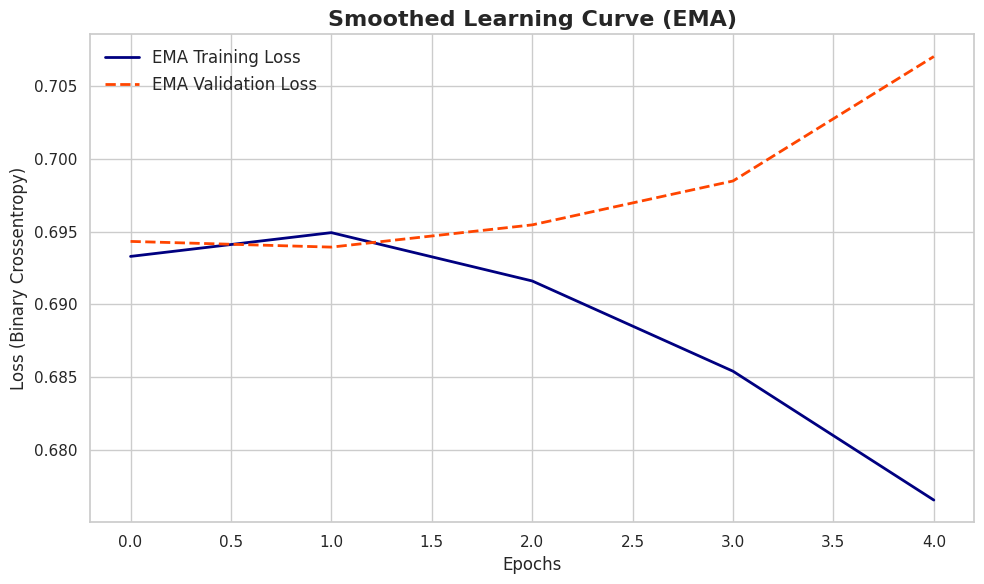

In [12]:
## 5.2. Plotting Training and Validation Loss (Smoothed with EMA)
import pandas as pd
loss_df = pd.DataFrame(history.history)
loss_df['EMA_train'] = loss_df['loss'].ewm(span=5, adjust=False).mean()
loss_df['EMA_val'] = loss_df['val_loss'].ewm(span=5, adjust=False).mean()
plt.figure(figsize=(10,6))
plt.plot(loss_df['EMA_train'], label='EMA Training Loss', color='navy', linewidth=2)
plt.plot(loss_df['EMA_val'], label='EMA Validation Loss', color='orangered', linewidth=2, linestyle='--')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss (Binary Crossentropy)", fontsize=12)
plt.title("Smoothed Learning Curve (EMA)", fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

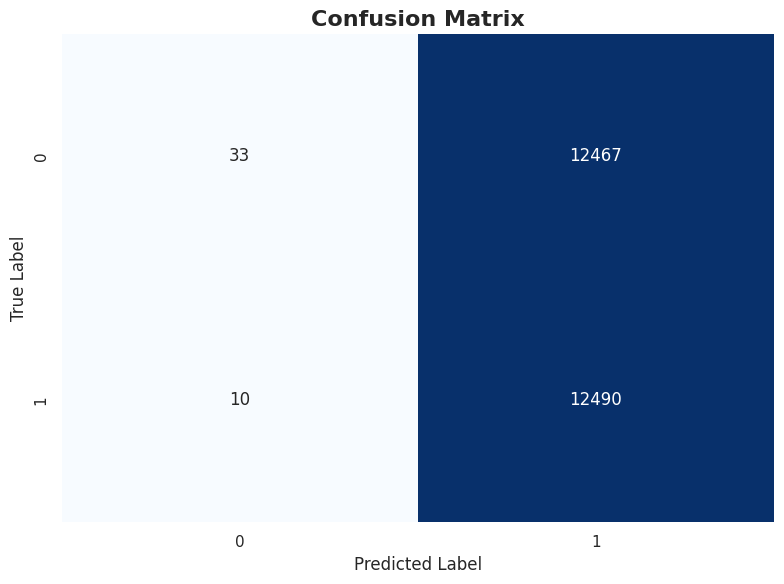

In [13]:
## 5.3. Confusion Matrix Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

In [14]:
## 5.4. Word Cloud of Positive and Negative Reviews
# Reconstruct word index from IMDB dataset for demonstration purposes
word_index = imdb.get_word_index()
index_word = {v+3: k for k, v in word_index.items()}  # +3 accounts for special tokens

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


In [15]:
def decode_review(review):
    # Convert review from integers back to words
    return " ".join([index_word.get(i, "?") for i in review if i >= 3])

# Generate word clouds for a sample of positive and negative reviews
n_samples = 100
positive_reviews = " ".join([decode_review(X_train[i]) for i in range(n_samples) if y_train[i]==1])
negative_reviews = " ".join([decode_review(X_train[i]) for i in range(n_samples) if y_train[i]==0])

wordcloud_pos = WordCloud(width=800, height=400, background_color='white', colormap='cool').generate(positive_reviews)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white', colormap='autumn').generate(negative_reviews)


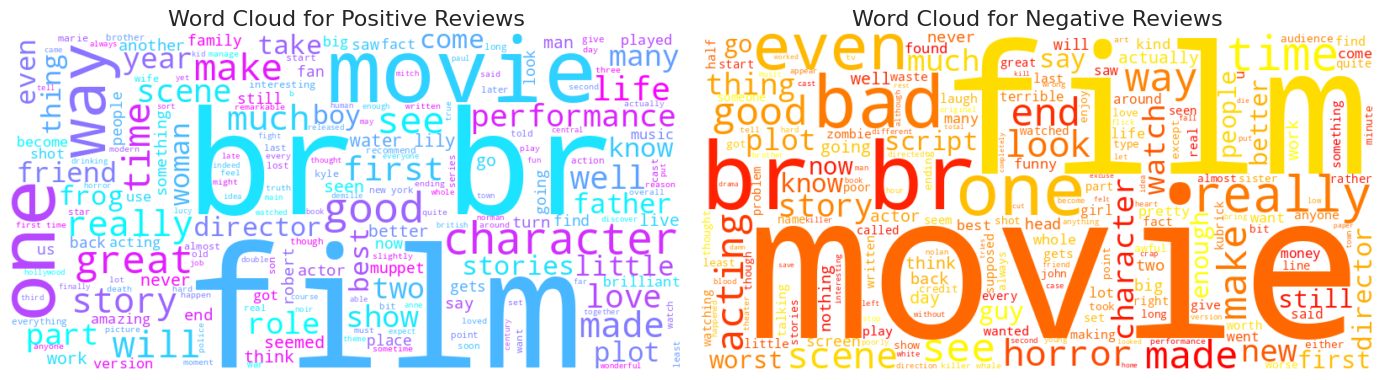

In [16]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Positive Reviews", fontsize=16)

plt.subplot(1,2,2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Negative Reviews", fontsize=16)
plt.tight_layout()
plt.show()